In [22]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

   CustomerID  Age  Gender  AnnualIncome  SpendingScore BrowserType  \
0        1001   23    Male        118266             98        Edge   
1        1002   57  Female         71930             39        Edge   
2        1003   50  Female        113230             43       Opera   
3        1004   50  Female         69083             15      Chrome   
4        1005   50  Female        109557             52     Firefox   

   PurchaseFrequency  LastPurchaseDaysAgo DeviceType  
0                  4                   31     Tablet  
1                 12                   10     Mobile  
2                 16                    9     Mobile  
3                  1                   50     Mobile  
4                 13                    4    Desktop  
----- Dataset shape and memory usage -----
Shape: (120, 9)
Memory usage:
 Index                   132
CustomerID              960
Age                     960
Gender                 6494
AnnualIncome            960
SpendingScore           960
B

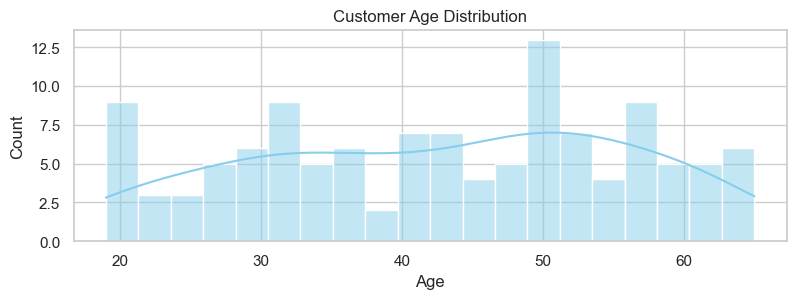

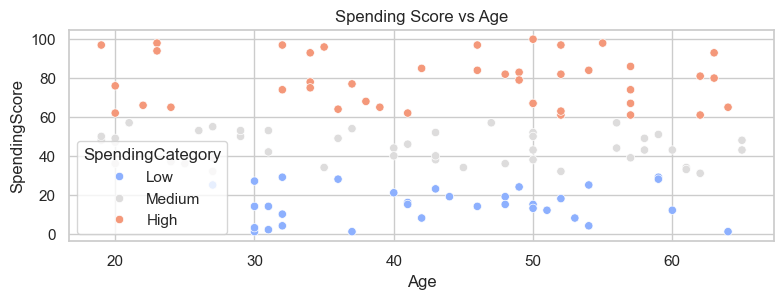

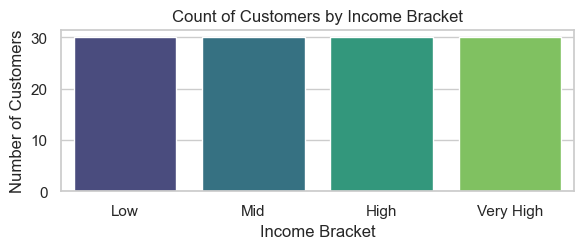

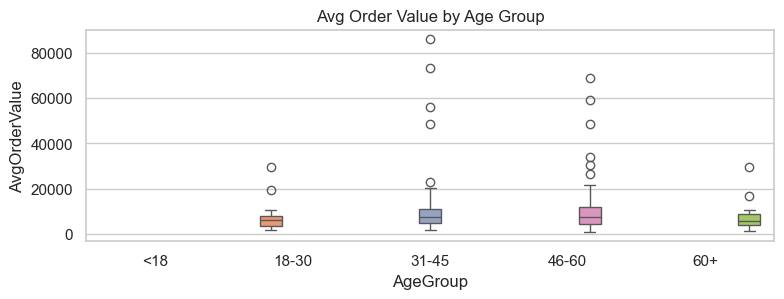

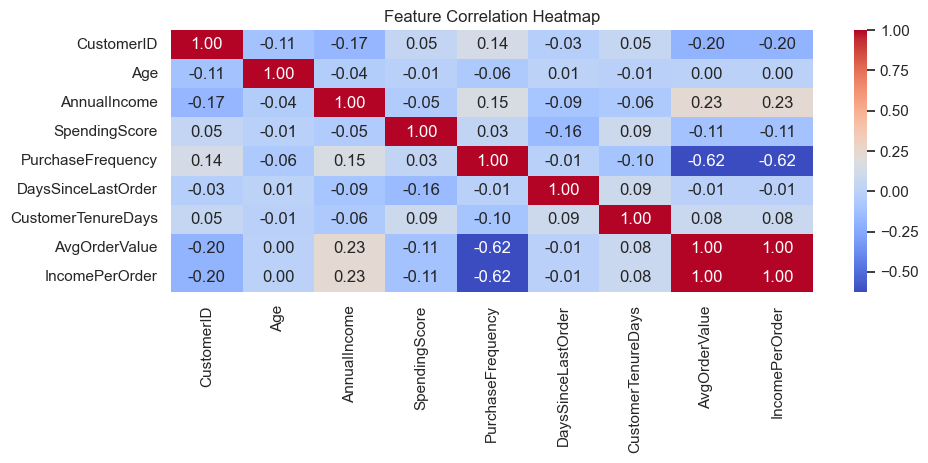

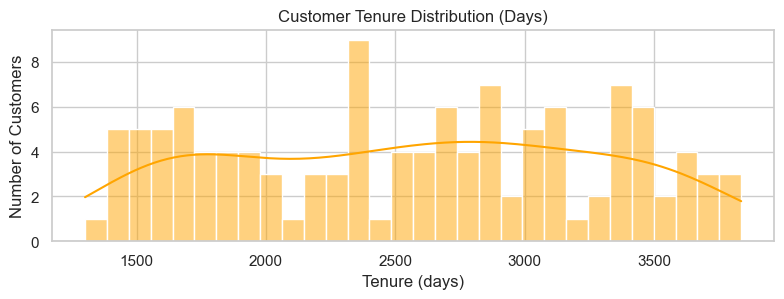

In [23]:
# -----------------------------
# Step 1: Load Dataset
# -----------------------------
data = pd.read_csv("ecommerce_customers_large.csv")
print(data.head())

# -----------------------------
# Step 2: Data Quality Report
# -----------------------------
print("----- Dataset shape and memory usage -----")
print("Shape:", data.shape)
print("Memory usage:\n", data.memory_usage(deep=True))

print("----- Missing values -----")
print(data.isnull().sum())

print("----- Data types -----")
print(data.dtypes)

print("----- Duplicate count -----")
print(data.duplicated().sum())

print("----- Statistical summary -----")
print(data.describe(include='all'))

# -----------------------------
# Task 2: Data Cleaning
# -----------------------------

# 1. Handle Missing Values
for col in data.columns:
    if data[col].isnull().any():
        if data[col].dtype == 'object':
            mode_val = data[col].mode(dropna=True)
            if not mode_val.empty:
                data[col] = data[col].fillna(mode_val[0])
        else:
            median_val = data[col].median()
            data[col] = data[col].fillna(median_val)

# 2. Remove Duplicates
data = data.drop_duplicates()

# 3. Fix Object Columns (Strip spaces and lowercase strings)
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].astype(str).str.strip().str.lower()

# -----------------------------
# Task 3: Outlier Detection & Treatment
# -----------------------------
num_cols = data.select_dtypes(include=np.number).columns
outlier_summary = {}

for col in num_cols:
    col_data = data[col].dropna()

    if col_data.std() == 0:
        continue  # Skip columns with no variation

    # IQR Method
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    iqr_outliers = data[(data[col] < lower) | (data[col] > upper)][col]

    # Z-score Method
    z_scores = np.abs(stats.zscore(col_data))
    zscore_outliers = col_data[z_scores > 3]

    # Combine
    total_outliers = set(iqr_outliers.index).union(set(zscore_outliers.index))
    percent = round(len(total_outliers) / len(data) * 100, 2)

    if percent < 5:
        data[col] = np.where(data[col] > upper, upper,
                      np.where(data[col] < lower, lower, data[col]))
        decision = "Capped"
    else:
        decision = "Needs Review"

    outlier_summary[col] = {
        "Outlier Count": len(total_outliers),
        "Percent of Total": percent,
        "Decision": decision,
        "IQR Bounds": (round(lower, 2), round(upper, 2))
    }

print("\n📊 Outlier Treatment Summary:")
for col, info in outlier_summary.items():
    print(f"\n▶ Column: {col}")
    for key, val in info.items():
        print(f"   - {key}: {val}")

# -----------------------------
# Task 4: Feature Engineering
# -----------------------------
feature_data = data.copy()

# 1. Simulate Registration Date and Calculate Tenure
np.random.seed(42)
feature_data["RegistrationDate"] = pd.to_datetime(
    np.random.choice(pd.date_range("2015-01-01", "2022-01-01"), size=len(feature_data))
)
feature_data["CustomerTenureDays"] = (pd.Timestamp.today() - feature_data["RegistrationDate"]).dt.days

# 2. Average Order Value (handle division by zero)
feature_data["PurchaseFrequency"] = feature_data["PurchaseFrequency"].replace(0, np.nan)
feature_data["AvgOrderValue"] = feature_data["AnnualIncome"] / feature_data["PurchaseFrequency"]
feature_data["AvgOrderValue"] = feature_data["AvgOrderValue"].replace([np.inf, -np.inf], np.nan)

# 3. Rename LastPurchaseDaysAgo to DaysSinceLastOrder
feature_data.rename(columns={"LastPurchaseDaysAgo": "DaysSinceLastOrder"}, inplace=True)

# 4. Age Groups
feature_data["AgeGroup"] = pd.cut(
    feature_data["Age"],
    bins=[0, 18, 30, 45, 60, 100],
    labels=["<18", "18-30", "31-45", "46-60", "60+"]
)

# 5. Income Brackets (handle unique values)
try:
    feature_data["IncomeBracket"] = pd.qcut(
        feature_data["AnnualIncome"],
        q=4,
        labels=["Low", "Mid", "High", "Very High"]
    )
except ValueError:
    feature_data["IncomeBracket"] = "Unknown"

# 6. Spending Categories
feature_data["SpendingCategory"] = pd.cut(
    feature_data["SpendingScore"],
    bins=[-1, 30, 60, 100],
    labels=["Low", "Medium", "High"]
)

# 7. Income per Order (handle division by zero)
feature_data["IncomePerOrder"] = feature_data["AnnualIncome"] / feature_data["PurchaseFrequency"]
feature_data["IncomePerOrder"] = feature_data["IncomePerOrder"].replace([np.inf, -np.inf], np.nan)

# -----------------------------
# Final Output
# -----------------------------
print("\n📦 Final Dataset with Engineered Features:")
print(feature_data[[
    "CustomerID", "CustomerTenureDays", "AvgOrderValue", "DaysSinceLastOrder",
    "Age", "AgeGroup", "AnnualIncome", "IncomeBracket",
    "SpendingScore", "SpendingCategory", "IncomePerOrder"
]].head())


sns.set(style="whitegrid")

# Make a clean copy and drop rows with NaN in critical columns
feature_data_plot = feature_data.copy()
feature_data_plot = feature_data_plot.dropna(subset=["Age", "SpendingScore", "AgeGroup", "AvgOrderValue", "IncomeBracket", "CustomerTenureDays"])

# 1. Age Distribution
plt.figure(figsize=(8, 5))
sns.histplot(
    feature_data_plot["Age"],
    bins=20,
    kde=True,
    color="skyblue",
    binrange=(feature_data_plot["Age"].min(), feature_data_plot["Age"].max())
)
plt.title("Customer Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.subplots_adjust(bottom=0.50)
plt.show()

# 2. Spending Score vs. Age
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=feature_data_plot,
    x="Age",
    y="SpendingScore",
    hue="SpendingCategory",
    palette="coolwarm"
)
plt.title("Spending Score vs Age")
plt.tight_layout()
plt.subplots_adjust(bottom=0.50)
plt.show()

# 3. Income Bracket Count (Fixed Warning)
plt.figure(figsize=(6, 4))
sns.countplot(
    data=feature_data_plot,
    x="IncomeBracket",
    hue="IncomeBracket",  # Fix: add hue to avoid futurewarning
    palette="viridis",
    order=["Low", "Mid", "High", "Very High"],
    legend=False          # Optional: removes duplicate legend
)
plt.title("Count of Customers by Income Bracket")
plt.xlabel("Income Bracket")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.subplots_adjust(bottom=0.50)
plt.show()

# 4. Age Group vs Avg Order Value (Fixed Warning)
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=feature_data_plot,
    x="AgeGroup",
    y="AvgOrderValue",
    hue="AgeGroup",      # Fix: add hue to avoid warning
    palette="Set2",
    legend=False
)
plt.title("Avg Order Value by Age Group")
plt.tight_layout()
plt.subplots_adjust(bottom=0.50)
plt.show()

# 5. Correlation Heatmap
plt.figure(figsize=(10, 6))
corr = feature_data_plot.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.subplots_adjust(bottom=0.50)
plt.show()

# 6. Customer Tenure Distribution
plt.figure(figsize=(8, 5))
sns.histplot(
    feature_data_plot["CustomerTenureDays"],
    bins=30,
    color="orange",
    kde=True,
    binrange=(feature_data_plot["CustomerTenureDays"].min(), feature_data_plot["CustomerTenureDays"].max())
)
plt.title("Customer Tenure Distribution (Days)")
plt.xlabel("Tenure (days)")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.subplots_adjust(bottom=0.50)
plt.show()


